# Gradients on primitives:
## `qiskit.algorithms.gradients`



Qiskit Demoday (Sep. 29th, 2022)

Atsushi Matsuo

*Acknowledgements: Imamichi-san and Hamamura-san's gradient implementations helped me a lot. Thank you so much and I appreciate it.*

## Index
1. Introduction
2. Gradient classes
3. Examples
4. Performance
5. Summary

# 1. Introduction

- New gradient classes in `qiskt-terra 0.22`.
- Unlike `opflow.gradients`, they use `primitives` to calculate the gradients of parameterized circuits.
- Can be used in many applications such as VQE, QNN, and so on.

# 2. Gradient classes
- `Sampler` and `Estimator` have 4 gradient classes each (so 8 classes in total).
- For Sampler:
  - `FiniteDiffSamplerGradient`
  - `LinCombSamplerGradient`
  - `ParamShiftSamplerGradient`
  - `SPSASamplerGradient`
- For estimator:
  - `FiniteDiffEstimatorGradient`
  - `LinCombEstimatorGradient`
  - `ParamShiftEstimatorGradient`
  - `SPSAEstimatorGradient`

We also have base classes (`BaseSamplerGradient` and `BaseEstimatorGradient`) and result classes (`SamplerGradientResult` and `EstimatorGradientResult`).

## APIs
APIs of the new gradient classes are similar to that of the primitives. Basically, the sampler gradients and estimator gradients have similar APIs, but the estimator gradients additionally requires `observables`.

In [ ]:
class BaseEstimatorGradient(ABC):
    
    def __init__(
        self,
        estimator: BaseEstimator,
        options: Options | None = None,
    ):
        ...

    def run(
        self,
        circuits: Sequence[QuantumCircuit],
        observables: Sequence[BaseOperator | PauliSumOp],
        parameter_values: Sequence[Sequence[float]],
        parameters: Sequence[Sequence[Parameter] | None] | None = None,
        **options,
    ) -> AlgorithmJob:
        ...

In [ ]:
@dataclass(frozen=True)
class EstimatorGradientResult:
    """Result of EstimatorGradient."""

    gradients: list[np.ndarray]
    """The gradients of the expectation values."""
    metadata: list[dict[str, Any]]
    """Additional information about the job."""
    options: Options
    """Primitive runtime options for the execution of the job."""

Let's see examples. It is faster to show than to explain.

# 3. Example of `ParamShiftEstimatorGradient`

In [1]:
from qiskit.algorithms.gradients import ParamShiftEstimatorGradient
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp

Use a `RealAmplitudes` circuit and a `ZI` operator. We have four parameters in the circuit.

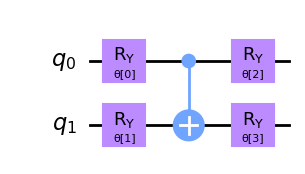

In [2]:
qc = RealAmplitudes(num_qubits=2, reps=1)
op = SparsePauliOp.from_list([("ZI", 1)])
qc.decompose().draw('mpl')

## Single execution example

In [3]:
# How to use the Estimator
estimator = Estimator()
values = [1, 2, 3, 4]

# run a job
job = estimator.run([qc], [op], [values])

# get results
result = job.result().values
result

array([0.83512712])

In [4]:
# How to use the ParamShiftEstimatorGradient
param_shift_grad = ParamShiftEstimatorGradient(estimator)

# run a job
job = param_shift_grad.run([qc], [op], [values])

# get results
result = job.result().gradients
result

[array([-0.22888997,  0.0061912 ,  0.        ,  0.42419313])]

APIs of the `ParamShiftEstimatorGradient` are similar to that of the `Estimator` 

## Example with batching

In [5]:
estimator = Estimator()

# Instantiate a grdient class
param_shift_grad = ParamShiftEstimatorGradient(estimator)

values1 = [1, 2, 3, 4]
values2 = [5, 6, 7, 8]

# run a job
job = param_shift_grad.run([qc]*2, [op]*2, [values1, values2])

# get results
result = job.result().gradients
result

[array([-0.22888997,  0.0061912 ,  0.        ,  0.42419313]),
 array([-1.33966333e-01, -9.61484667e-01,  6.93889390e-17, -3.10120536e-01])]

## Example with specified parameters
We use a list of parameters to calculate only the gradients of the specified parameters.

In [7]:
# EstimatorGradient
param_shift_grad = ParamShiftEstimatorGradient(estimator)

param = [p for p in qc.parameters]

# run a job
# param = list of parameters in the quantum circuit
job = param_shift_grad.run([qc]*2, [op]*2, [values, values], [param, param[:2]])

# get results
result = job.result()
result.gradients

[array([-0.22888997,  0.0061912 ,  0.        ,  0.42419313]),
 array([-0.22888997,  0.0061912 ])]

In [8]:
# metadata in EstimatorGradientResult stores which parameters' graidents were caluclated
print("result.metadata")
print(result.metadata[0])
print(result.metadata[1])

result.metadata
{'parameters': [ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3])]}
{'parameters': [ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1])]}


This functionality is useful especially in QNNs. Some parameters in QNNs are used to encode input data. We don't need to calculate gradients for those parameters.

# Performance analysis

- Used a `RealAmplitudes` circuit with 10 qubits, and changed the number of the layers in the circuit.
- The parameter shift gradient is used for a gradient method.
- The Primitive-based gradient is much faster than the Opflow gradient (~ 100 times).
- `normalized` means `gradient_time/foward_time` to show the overhead of gradient calculation.
- Primitive-based gradients avoids copying quantum circuits as much as possible for speed.

<img src="comparison1.png" width="80%">



<img src="comparison2.png" width="80%">

| name            |   forward_avg |   gradient_avg |   normalized_exec_time | 
|-----------------|---------------|----------------|------------------------|
| opflow_rep0     |    0.0211032  |      3.5008    |              165.889   |
| primitive_rep0  |    0.00701542 |      0.0438078 |                6.24451 |
| opflow_rep1     |    0.0170194  |      8.82974   |              518.804   |
| primitive_rep1  |    0.00849342 |      0.111733  |               13.1553  |
| opflow_rep5     |    0.030078   |     43.4287    |             1443.87    |
| primitive_rep5  |    0.015219   |      0.787144  |               51.7212  |
| opflow_rep10    |    0.0505518  |    125.67      |             2485.96    |
| primitive_rep10 |    0.0201492  |      2.02269   |              100.386   |

## Summary
- New gradient classes in `qiskit-terra 0.22`.
  - They use primitives to calculate the gradients of parametarized circuits.
  - `Sampler` and `Estimator` have 4 gradient classes each (so 8 classes in total).
- APIs are similar to primitives and easy to use. 
  - e.g., `param_shift_grad.run([qc], [op], [values])`
- Support batching and can caluclate the gradients for specified parameters.
- Much faster than exisiting the Opflow gradients.